<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Deep Learning for NLP
  </div> 
  
<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
    <font color=orange>II - 2 </font>
  Sequence to Sequence
  </div> 

  <div style="
      font-weight: normal; 
      font-size: 20px; 
      text-align: center; 
      padding: 15px;">
    b. Chatbot
  </div> 

  <div style=" float:right; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  Jean-baptiste AUJOGUE
  </div> 

### Part I

1. Word Embedding

2. Sentence Classification

3. Language Modeling

4. Sequence Labelling


### Part II

1. Text Classification

2. <font color=orange>**Sequence to sequence**</font>


### Part III

8. Abstractive Summarization

9. Question Answering

10. Chatbot


</div>

***

<a id="plan"></a>

| | | | |
|------|------|------|------|
| **Content** | [Corpus](#corpus) | [Modules](#modules) | [Model](#model) | 



# Packages

In [1]:
from __future__ import unicode_literals, print_function, division

import sys
import warnings
import os
from io import open
import unicodedata
import string
import time
import math
import re
import random
import pickle
import copy
from unidecode import unidecode
import itertools
import matplotlib
import matplotlib.pyplot as plt


# for special math operation
from sklearn.preprocessing import normalize


# for manipulating data 
import numpy as np
#np.set_printoptions(threshold=np.nan)
import pandas as pd
import bcolz # see https://bcolz.readthedocs.io/en/latest/intro.html
import pickle


# for text processing
import gensim
from gensim.models import KeyedVectors
#import spacy
import nltk
#nltk.download()
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer


# for deep learning
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

warnings.filterwarnings("ignore")
print('python version :', sys.version)
print('pytorch version :', torch.__version__)
print('DL device :', device)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


python version : 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
pytorch version : 1.5.0
DL device : cuda


In [2]:
path_to_DL4NLP = os.path.dirname(os.getcwd())
path_to_data   = 'D:\\data'

In [3]:
sys.path.append(path_to_DL4NLP + '\\lib')

<a id="corpus"></a>

# Corpus

[Back to top](#plan)

Le texte est importé et mis sous forme de liste, où chaque élément représente un texte présenté sous forme d'une liste de mots.<br> Le corpus est donc une fois importé sous le forme :<br>

- corpus = [text]<br>
- text   = [word]<br>
- word   = str<br>

In [4]:
# --------------------------- Normalisation -------------------------------
def normalizeString(s):
    '''Remove rare symbols from a string'''
    def unicodeToAscii(s):
        """Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427"""
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
 
    s = unicodeToAscii(s.lower().strip())
    #s = re.sub(r"[^a-zA-Z0-9?&\%\-\_]+", r" ", s) 
    s = re.sub("\(", r" ( ", s)
    s = re.sub("\)", r" ) ", s)
    s = re.sub(r"\.", r" . ", s)
    s = re.sub(r",", r" , ", s)
    s = re.sub(r"!", r" ! ", s)
    s = re.sub(r":", r" : ", s)
    s = re.sub(r"-", r" - ", s)
    s = re.sub(r"'", r" ' ", s)
    s = re.sub(r";", r" ; ", s)
    s = re.sub(r' +', r' ', s).strip()
    return s 



#--------------------- import des dialogues --------------------
def importDialogues(path, limit = None):
    '''Import a textfile containing dialogues and returns a list, each element 
       corresponding to a dialogue and also being under the form of a list, with 
       each element being a list of two elements : an element giving a user 
       utterance and another element giving the bot response. Both elements are 
       normalized strings.
       Ex. The dialogue :
       
               hi    hello what can i help you with today
               can you book a table    i m on it
               
       now becomes :
       
              [['hi', 'hello what can i help you with today'], 
               ['can you book a table', 'i m on it']]
               
       Lines corresponding to user utterance with no bot response are discarted.
    '''
    def cleanS(s):
        cleans = normalizeString(s)
        cleans = cleans.replace('?', ' ? ').strip()
        return cleans
    
    dialogues = []
    dialogues_import = open(path, encoding='utf-8').read().strip().split('\n\n')
    for i, d in enumerate(dialogues_import):
        dialogue = []
        lines = d.split('\n')
        for l in lines:
            if len(l.split('\t')) == 2 :
                pair = [cleanS(s) for s in l.split('\t')]
                dialogue.append(pair)
            elif len(l.split('\t')) == 3 :
                pair = [cleanS(s) for s in l.split('\t')[:2]]
                dialogue.append(pair)
        dialogues.append(dialogue)
        if limit is not None and i == limit -1 : break
    return dialogues


def getUniqueQAs(dialogues) :
    uniq = []
    for qa in dialogues :
        if qa not in uniq : uniq.append(qa)
    return uniq



#------------------ Dictionnaire des mots variables -----------------------------
def motVar(file):
    '''Applies to the Master's program dataset.
       Import the collection of pairs token-content for a set of variable words.
    '''
    lines = open(file, encoding='utf-8').read().strip().split('\n')
    motsVar = {}
    for l in lines :
        cle, valeur = l.split('\t')
        motsVar[cle.lower()] = valeur
    return motsVar

In [5]:
motsVar    = motVar(path_to_data + '\\M2DS\\M2DS_2019_07\\chatbot-M2-DS-Variables.txt')
dialogues  = importDialogues(path_to_data + '\\M2DS\\M2DS_2019_10\\ChatbotDS_P_Train.tsv')
dialogues_tst = importDialogues(path_to_data + '\\M2DS\\M2DS_2019_10\\ChatbotDS_P_Test.tsv')

In [6]:
qa_trn = [qa for dialogue in dialogues for qa in dialogue] # getUniqueQAs(
qa_tst = [qa for dialogue in dialogues_tst for qa in dialogue] # getUniqueQAs(

print(len(qa_trn), len(qa_tst))

200224 20561


In [7]:
for qa in dialogues[0] : print(qa[0], '\t', qa[1])

il vaut mieux suivre quel parcours  ? 	 les deux parcours sont equivalents , c ' est a vous de faire un choix .
quand est ce que commence les cours  ? 	 la rentree est le daterentree
comment je prend contact avec la scolarite  ? 	 les contacts de la scolarite sont accessibles sur : sitescolarite
est ce que il y a des cours en anglais  ? 	 plusieurs supports de cours sont en anglais
tous les cours sont obligatoires  ? 	 tous les cours sont obligatoires , il n ' existe pas d ' options .
merci pour les renseignements 	 je vous en prie
peux tu m ' aider  ? 	 je suis la pour vous renseigner sur le master 2 data science .
le cours de data visualisation est - il en ligne  ? 	 vous devriez prendre contact avec l ' enseignant de l ' ue et lui demander
j ' ai envie de faire de la data science 	 alors vous devriez songer a candidater a ce master !
il y a des livres a lire en statistique  ? 	 vous devriez prendre contact avec l ' enseignant de l ' ue et lui demander
il y a combien de candidats  ? 

<a id="modules"></a>

# 1 Modules

### 1.1 Word Embedding module

[Back to top](#plan)

All details on Word Embedding modules and their pre-training are found in **Part I - 1**. We consider here a FastText model trained following the Skip-Gram training objective.

In [8]:
from libDL4NLP.models.Word_Embedding import Word2Vec as myWord2Vec
from libDL4NLP.models.Word_Embedding import Word2VecConnector
from libDL4NLP.utils.Lang import Lang

In [9]:
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath, get_tmpfile

**Option 1** : Load pretrained

In [10]:
# load
word2vec_in  = torch.load(path_to_DL4NLP + '\\saves\\DL4NLP_II2b_w2v_in_M2DS.pt')
word2vec_out = torch.load(path_to_DL4NLP + '\\saves\\DL4NLP_II2b_w2v_out_M2DS.pt')

**Option 2** : Train new model

In [10]:
corpus_in  = [['SOS'] + [w for w in qa[0].split(' ')] + ['EOS'] for qa in qa_trn]
corpus_out = [['SOS'] + [w for w in qa[1].split(' ')] + ['EOS'] for qa in qa_trn]

In [53]:
def prepareWord2vec(corpus, epochs) :
    fastText_word2vec = FastText(size = 75, 
                                 window = 5, 
                                 min_count = 1, 
                                 negative = 20,
                                 sg = 1)
    fastText_word2vec.build_vocab(corpus)
    print(len(fastText_word2vec.wv.vocab))
    fastText_word2vec.train(sentences = corpus, 
                            epochs = epochs,
                            total_examples = fastText_word2vec.corpus_count)
    word2vec = Word2VecConnector(fastText_word2vec)
    return word2vec

In [54]:
word2vec_in  = prepareWord2vec(corpus_in, epochs = 20)
word2vec_out = prepareWord2vec(corpus_out, epochs = 20)

782
896


In [11]:
word2vec_in.word2vec.most_similar('bonjou')

[('bonjour', 0.9804752469062805),
 ('mal', 0.8117103576660156),
 ('bien', 0.6764619946479797),
 ('principal', 0.672505259513855),
 ('principalement', 0.5881912112236023),
 ('english', 0.578591525554657),
 ('handle', 0.5670300722122192),
 ('coucou', 0.5658980011940002),
 ('ok', 0.5612411499023438),
 ('speak', 0.5596966743469238)]

In [12]:
word2vec_out.word2vec.most_similar('bonjou')

[('bonjour', 0.968519926071167),
 ('accord', 0.7767391204833984),
 ('comment', 0.6192842721939087),
 ('aider', 0.5911822319030762),
 ('accordez', 0.5513397455215454),
 ('vais', 0.4964368939399719),
 ('puis', 0.4900757372379303),
 ('gardez', 0.48046615719795227),
 ('merci', 0.4791063368320465),
 ('test', 0.47400200366973877)]

In [58]:
# save
#torch.save(word2vec_in, path_to_DL4NLP + '\\saves\\DL4NLP_II2b_w2v_in_M2DS.pt')
#torch.save(word2vec_out, path_to_DL4NLP + '\\saves\\DL4NLP_II2b_w2v_out_M2DS.pt')

<a id="model"></a>

# 2 Encoder-Decoder Model

[Back to top](#plan)


In [20]:
from libDL4NLP.models import EncoderDecoder
from libDL4NLP.utils  import AttentionViewer, AttentionViewerOnWords

#### Training

In [15]:
max([len(qa[1].split(' ')) for qa in qa_trn])

69

In [16]:
chatbot = EncoderDecoder(device = torch.device("cpu"),
                         tokenizer = lambda s : normalizeString(s).split(' '),
                         word2vec_in = word2vec_in,
                         word2vec_out = word2vec_out,
                         hidden_dim_in = 100,
                         hidden_dim_out = 100,
                         n_layers_in = 2,
                         n_layers_out = 2,
                         bound = 75,
                         dropout = 0.15,
                         decoder_warm_start = True,
                         decoder_type = 'attention',
                         optimizer = optim.AdamW)

chatbot.nbParametres()

661897

In [20]:
batches = chatbot.generatePackedSentences(qa_trn, batch_size = 32)
len(batches)

6257

In [25]:
chatbot.fit(batches, epochs = 1, lr = 0.0025, tf_ratio = 0.75, print_every = 100)
chatbot.fit(batches, epochs = 1, lr = 0.001, tf_ratio = 0.5, print_every = 100)
chatbot.fit(batches, epochs = 1, lr = 0.00025, tf_ratio = 0.5, print_every = 100)

epoch 1
0m 21s (- 22m 20s) (100 1%) loss : 5.101  accuracy : 9.5 %
0m 44s (- 22m 16s) (200 3%) loss : 4.310  accuracy : 18.2 %
1m 6s (- 22m 5s) (300 4%) loss : 3.972  accuracy : 26.0 %
1m 30s (- 21m 59s) (400 6%) loss : 3.718  accuracy : 31.8 %
1m 53s (- 21m 45s) (500 7%) loss : 3.201  accuracy : 38.3 %
2m 16s (- 21m 30s) (600 9%) loss : 2.788  accuracy : 47.3 %
2m 39s (- 21m 3s) (700 11%) loss : 2.363  accuracy : 53.9 %
3m 2s (- 20m 44s) (800 12%) loss : 2.247  accuracy : 55.5 %
3m 26s (- 20m 28s) (900 14%) loss : 2.024  accuracy : 59.5 %
3m 50s (- 20m 10s) (1000 15%) loss : 1.644  accuracy : 66.9 %
4m 14s (- 19m 51s) (1100 17%) loss : 1.886  accuracy : 62.6 %
4m 37s (- 19m 28s) (1200 19%) loss : 1.942  accuracy : 62.2 %
4m 57s (- 18m 56s) (1300 20%) loss : 1.891  accuracy : 64.9 %
5m 21s (- 18m 33s) (1400 22%) loss : 1.650  accuracy : 66.7 %
5m 43s (- 18m 10s) (1500 23%) loss : 1.655  accuracy : 66.6 %
6m 5s (- 17m 42s) (1600 25%) loss : 1.504  accuracy : 70.3 %
6m 30s (- 17m 26s) (1

5m 13s (- 27m 26s) (1000 15%) loss : 0.285  accuracy : 92.0 %
5m 47s (- 27m 8s) (1100 17%) loss : 0.239  accuracy : 93.6 %
6m 17s (- 26m 29s) (1200 19%) loss : 0.236  accuracy : 93.0 %
6m 48s (- 25m 58s) (1300 20%) loss : 0.315  accuracy : 91.0 %
7m 21s (- 25m 30s) (1400 22%) loss : 0.331  accuracy : 90.6 %
7m 50s (- 24m 53s) (1500 23%) loss : 0.241  accuracy : 93.2 %
8m 22s (- 24m 22s) (1600 25%) loss : 0.221  accuracy : 93.5 %
8m 54s (- 23m 51s) (1700 27%) loss : 0.314  accuracy : 90.5 %
9m 26s (- 23m 23s) (1800 28%) loss : 0.204  accuracy : 94.1 %
9m 59s (- 22m 54s) (1900 30%) loss : 0.335  accuracy : 90.4 %
10m 33s (- 22m 28s) (2000 31%) loss : 0.295  accuracy : 91.1 %
11m 4s (- 21m 56s) (2100 33%) loss : 0.306  accuracy : 90.6 %
11m 36s (- 21m 23s) (2200 35%) loss : 0.203  accuracy : 94.0 %
12m 8s (- 20m 52s) (2300 36%) loss : 0.227  accuracy : 93.6 %
12m 38s (- 20m 18s) (2400 38%) loss : 0.254  accuracy : 92.1 %
13m 10s (- 19m 48s) (2500 39%) loss : 0.302  accuracy : 91.0 %
13m 4

In [17]:
# save
#torch.save(chatbot.state_dict(), path_to_DL4NLP + '\\saves\\DL4NLP_II2b_encoder_attndecoder_M2DS.pth')

# load
#chatbot.load_state_dict(torch.load(path_to_DL4NLP + '\\saves\\DL4NLP_II2b_encoder_attndecoder_M2DS.pth'))

<All keys matched successfully>

#### Evaluation

In [29]:
chatbot.eval()
chatbot.compute_accuracy(qa_tst, batch_size = 16)

49.044307183502745

In [18]:
def ReplaceMotVar(motsVar, raw_sentence):
    sentence = []
    word_list = raw_sentence.split(' ')
    for word in word_list :
        if word in motsVar.keys() :
            sentence.append(motsVar[word])
        else :
            sentence.append(word)
    return ' '.join(sentence)


def repair(sentence) :
    s = re.sub(" ' ", "'", sentence)
    s = re.sub(" - ", "-", s)
    s = re.sub(" ,", ",", s)
    s = re.sub(r'(?<=\d) \. (?=\d)', '.', s)
    s = re.sub(" \.", ".", s)
    s = re.sub("\( ", "(", s)
    s = re.sub(" \)", ")", s)
    s = s[0].upper() + s[1:]
    return s


def InteractiveEvaluation(agent) :
    print("Interactive mode (Press 'q' to exit)")
    agent.eval()
    while True :
        text = input('User : ')
        #print('User : {}'.format(text))
        if text == 'eoc' or text == 'q' or text == 'quit' : 
            break
        reponse = agent(text)
        reponse = ReplaceMotVar(motsVar, reponse)
        reponse = repair(reponse)
        print('Bot  : {}'.format(reponse))

In [137]:
InteractiveEvaluation(chatbot)

Interactive mode (Press 'q' to exit)
User : coucou
Bot  : Bonjour, comment puis-je vous aider ?
User : salut
Bot  : Bonjour, comment puis-je vous aider ?
User : tu fais quoi
Bot  : Je suis la pour vous renseigner sur le master 2 data science.
User : cool, sinon tu sais faire quoi
Bot  : Il y a plusieurs tp, sur les reseaux bayesien, les modeles de markov cache ainsi que les reseaux de neurones profond.
User : bonjour
Bot  : Bonjour, comment puis-je vous aider ?
User : caca
Bot  : Il y a plusieurs tp sur sur et et r : introduction a sas, programmation avancee avec sas, les tests statistiques.
User : je ne vois pas le rapport
Bot  : C'est dommage, vous en aurez besoin si vous souhaitez faire ce master.
User : j'aurai besoin du rapport ?
Bot  : Le master data science est un double cursus info-math de haut niveau qui permet aux etudiants d’acquerir des competences fortes en statistique et en informatique tres demandees actuellement par les entreprises.
User : ha super
Bot  : Merci, j'esper

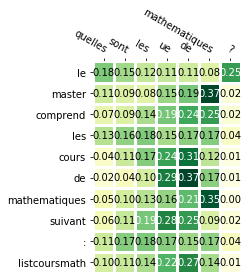

quelles sont les ue de mathematiques ?  - le
quelles sont les ue de mathematiques ?  - master
quelles sont les ue de mathematiques ?  - comprend
quelles sont les ue de mathematiques ?  - les
quelles sont les ue de mathematiques ?  - cours
quelles sont les ue de mathematiques ?  - de
quelles sont les ue de mathematiques ?  - mathematiques
quelles sont les ue de mathematiques ?  - suivant
quelles sont les ue de mathematiques ?  - :
quelles sont les ue de mathematiques ?  - listcoursmath



'le master comprend les cours de mathematiques suivant : listcoursmath'

In [42]:
chatbot.eval()
chatbot('quelles sont les ue de mathématiques ?', attention_method = AttentionViewer)
chatbot('quelles sont les ue de mathématiques ?', attention_method = AttentionViewerOnWords)

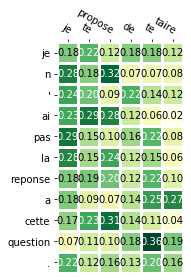

je te propose de te taire  - je
je te propose de te taire  - n
je te propose de te taire  - '
je te propose de te taire  - ai
je te propose de te taire  - pas
je te propose de te taire  - la
je te propose de te taire  - reponse
je te propose de te taire  - a
je te propose de te taire  - cette
je te propose de te taire  - question
je te propose de te taire  - .



"je n ' ai pas la reponse a cette question ."

In [45]:
chatbot.eval()
chatbot('je te propose de te taire', attention_method = AttentionViewer)
chatbot('je te propose de te taire', attention_method = AttentionViewerOnWords)

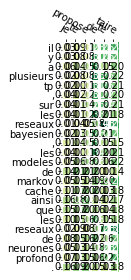

je te propose de te taire  - il
je te propose de te taire  - y
je te propose de te taire  - a
je te propose de te taire  - plusieurs
je te propose de te taire  - tp
je te propose de te taire  - ,
je te propose de te taire  - sur
je te propose de te taire  - les
je te propose de te taire  - reseaux
je te propose de te taire  - bayesien
je te propose de te taire  - ,
je te propose de te taire  - les
je te propose de te taire  - modeles
je te propose de te taire  - de
je te propose de te taire  - markov
je te propose de te taire  - cache
je te propose de te taire  - ainsi
je te propose de te taire  - que
je te propose de te taire  - les
je te propose de te taire  - reseaux
je te propose de te taire  - de
je te propose de te taire  - neurones
je te propose de te taire  - profond
je te propose de te taire  - .



'il y a plusieurs tp , sur les reseaux bayesien , les modeles de markov cache ainsi que les reseaux de neurones profond .'

In [22]:
chatbot.eval()
chatbot('je te propose de te taire', attention_method = AttentionViewer)
chatbot('je te propose de te taire', attention_method = AttentionViewerOnWords)

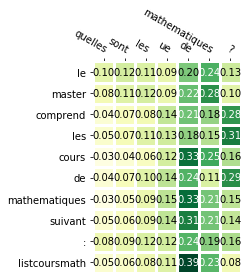

quelles sont les ue de mathematiques ?  - le
quelles sont les ue de mathematiques ?  - master
quelles sont les ue de mathematiques ?  - comprend
quelles sont les ue de mathematiques ?  - les
quelles sont les ue de mathematiques ?  - cours
quelles sont les ue de mathematiques ?  - de
quelles sont les ue de mathematiques ?  - mathematiques
quelles sont les ue de mathematiques ?  - suivant
quelles sont les ue de mathematiques ?  - :
quelles sont les ue de mathematiques ?  - listcoursmath



'le master comprend les cours de mathematiques suivant : listcoursmath'

In [21]:
chatbot.eval()
chatbot('quelles sont les ue de mathématiques ?', attention_method = AttentionViewer)
chatbot('quelles sont les ue de mathématiques ?', attention_method = AttentionViewerOnWords)